# causalAssembly

In [2]:
import pandas as pd
import numpy as np

from causalAssembly.models_dag import ProductionLineGraph
from causalAssembly.drf_fitting import fit_drf

## demo setup

with alternating sample sizes

In [26]:
seed = 2023
n_select = 2000

assembly_line_data = ProductionLineGraph.get_data()

# take subsample for demonstration purposes
assembly_line_data = assembly_line_data.sample(
    n_select, random_state=seed, replace=False
)

# load in ground truth
assembly_line = ProductionLineGraph.get_ground_truth()

# fit drf and sample for entire line
assembly_line.drf = fit_drf(assembly_line, data=assembly_line_data)
assembly_line_sample = assembly_line.sample_from_drf(size=n_select)

# fit drf and sample for station3
assembly_line.Station3.drf = fit_drf(assembly_line.Station3, data=assembly_line_data)
station3_sample = assembly_line.Station3.sample_from_drf(size=n_select)

In [35]:
# save data to csv
assembly_line_sample.to_csv(f'data/causalAssembly/assembly_line_data_{assembly_line_sample.shape[0]}.csv', index=False)
station3_sample.to_csv(f'data/causalAssembly/station3_data_{station3_sample.shape[0]}.csv', index=False)

# save ground truth to csv
assembly_line.ground_truth.to_csv('data/causalAssembly/assembly_line_ground_truth.csv', index=False)
assembly_line.Station3.ground_truth.to_csv('data/causalAssembly/station3_ground_truth.csv', index=False)

get and save data for Station2

In [54]:
n_select = 2000

# fit drf and sample for station3
assembly_line.Station2.drf = fit_drf(assembly_line.Station2, data=assembly_line_data)
station2_sample = assembly_line.Station2.sample_from_drf(size=n_select)

# save data to csv
station2_sample.to_csv(f'data/causalAssembly/station2_data_{station2_sample.shape[0]}.csv', index=False)
assembly_line.Station2.ground_truth.to_csv('data/causalAssembly/station2_ground_truth.csv', index=False)

investigate ground truths

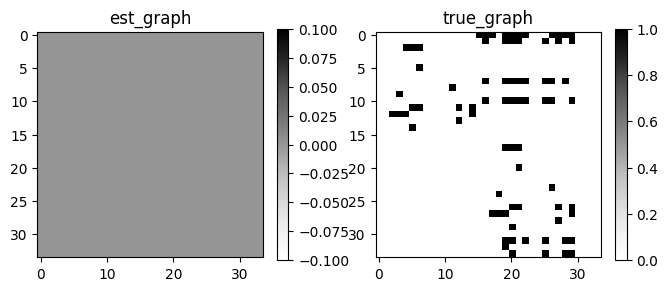

In [53]:
GraphDAG(
    np.zeros(assembly_line.Station2.ground_truth.to_numpy().shape), 
    assembly_line.Station2.ground_truth.to_numpy()
    )

### DAG-MA

In [21]:
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG

#### IID Test data

create data

In [10]:
dag = DAG.scale_free(n_nodes=34, n_edges=40)
data = IIDSimulation(W=dag, n=10000, method='linear', sem_type='logistic')

2024-06-18 08:56:40,150 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


learn model

100%|██████████| 1120000/1120000.0 [04:49<00:00, 3870.36it/s] 


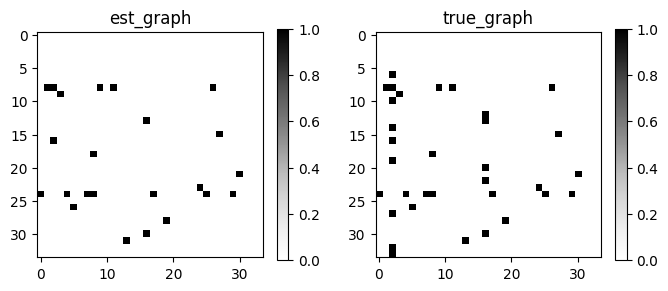

{'fdr': 0.0, 'tpr': 0.697, 'fpr': 0.0, 'shd': 10, 'nnz': 23, 'precision': 1.0, 'recall': 0.697, 'F1': 0.8214, 'gscore': 0.697}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [25]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(data.X, max_iter=1e6) > 0.5).astype("int32")
GraphDAG(W_est, data.B)
metrics = MetricsDAG(W_est, data.B)
print(metrics.metrics)

#### Station 3

##### sample size 500

In [24]:
# store data as array 
station3_sample_array = station3_sample.to_numpy()

# store ground truth as array
station3_ground_truth = assembly_line.Station3.ground_truth.to_numpy()

In [20]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(station3_sample_array, max_iter=1e6) > 0.5).astype("int32")

100%|██████████| 1120000/1120000.0 [05:12<00:00, 3582.97it/s]


AttributeError: station3 is not a valid attribute (cell name?)

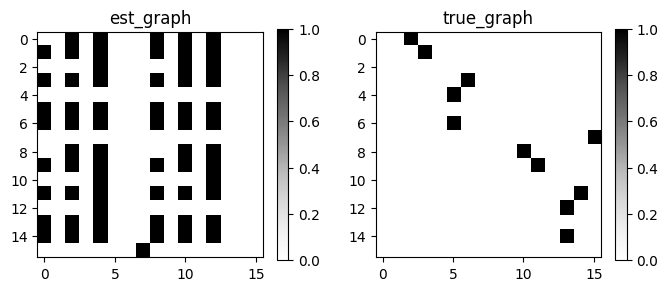

{'fdr': 0.9688, 'tpr': 0.1818, 'fpr': 0.5688, 'shd': 68, 'nnz': 64, 'precision': 0.0312, 'recall': 0.1818, 'F1': 0.0533, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [23]:
# plot prediction vs orginal
GraphDAG(W_est, station3_ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, station3_ground_truth)
print(metrics.metrics)

##### sample size 2000

In [36]:
data = pd.read_csv('data/causalAssembly/station3_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station3_ground_truth.csv').to_numpy()

In [29]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")

# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
print(metrics.metrics)

100%|██████████| 1120000/1120000.0 [26:33<00:00, 702.85it/s]


IndexError: index 16 is out of bounds for axis 0 with size 16

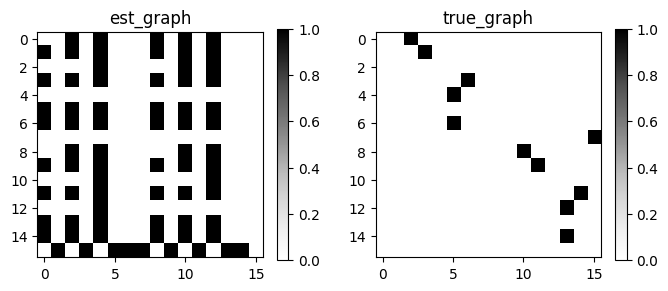

{'fdr': 0.9722, 'tpr': 0.1818, 'fpr': 0.6422, 'shd': 76, 'nnz': 72, 'precision': 0.0278, 'recall': 0.1818, 'F1': 0.0482, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [37]:
# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
print(metrics.metrics)

#### Station 2

In [55]:
data = pd.read_csv('data/causalAssembly/station2_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

In [56]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")

# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
print(metrics.metrics)

 25%|██▍       | 276058/1120000.0 [09:30<29:02, 484.29it/s]  


KeyboardInterrupt: 

### NOTEARS LINEAR

In [8]:
from castle.algorithms import Notears
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-19 12:15:49,735 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-06-19 12:15:49,796 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


#### IID_Test data

2024-06-18 15:42:37,387 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-18 15:42:37,395 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16
2024-06-18 15:42:37,843 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=6.738e-01, loss=171.797, rho=1.0e+00
2024-06-18 15:42:38,105 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=4.604e-01, loss=4.593, rho=1.0e+00
2024-06-18 15:42:38,481 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=2.170e-01, loss=6.636, rho=1.0e+01
2024

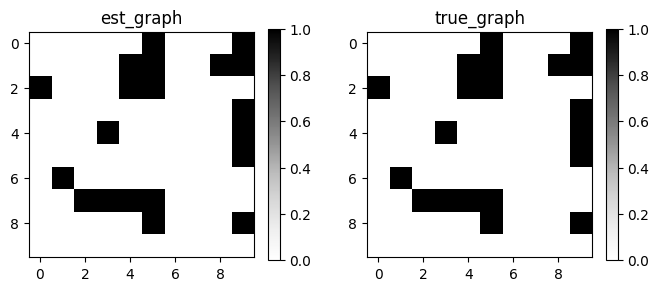

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 20, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [61]:
X, true_dag, _ = load_dataset('IID_Test')
n = Notears()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

#### assembly line

In [9]:
data = pd.read_csv('data/causalAssembly/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/assembly_line_ground_truth.csv').to_numpy()

n = Notears()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

2024-06-19 12:15:53,378 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=500, d=98, iter_=100, h_=1e-08, rho_=1e+16


KeyboardInterrupt: 

#### station 3

##### sample size 2000

2024-06-19 12:19:50,308 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=16, iter_=100, h_=1e-08, rho_=1e+16


2024-06-19 12:19:50,613 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=1.273e+00, loss=475.790, rho=1.0e+00
2024-06-19 12:19:50,681 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=1.230e+00, loss=89.663, rho=1.0e+00
2024-06-19 12:19:50,856 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=9.994e-01, loss=96.957, rho=1.0e+01
2024-06-19 12:19:50,948 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=5.373e-01, loss=169.897, rho=1.0e+02
2024-06-19 12:19:51,113 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=2.064e-01

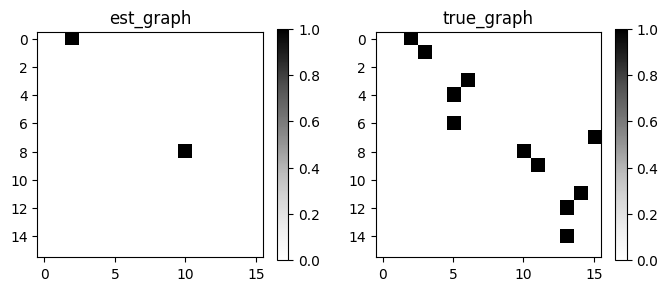

{'fdr': 0.0, 'tpr': 0.1818, 'fpr': 0.0, 'shd': 9, 'nnz': 2, 'precision': 1.0, 'recall': 0.1818, 'F1': 0.3077, 'gscore': 0.1818}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [11]:
data = pd.read_csv('data/causalAssembly/station3_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station3_ground_truth.csv').to_numpy()

n = Notears()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

#### station2

##### sample size 2000

2024-06-19 12:21:18,818 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=34, iter_=100, h_=1e-08, rho_=1e+16
2024-06-19 12:21:29,188 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=8.112e+00, loss=4690538063731.319, rho=1.0e+00
2024-06-19 12:21:29,236 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=8.107e+00, loss=2512283877873.856, rho=1.0e+00
2024-06-19 12:21:29,283 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=8.106e+00, loss=2512283878169.973, rho=1.0e+01
2024-06-19 12:21:29,331 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py

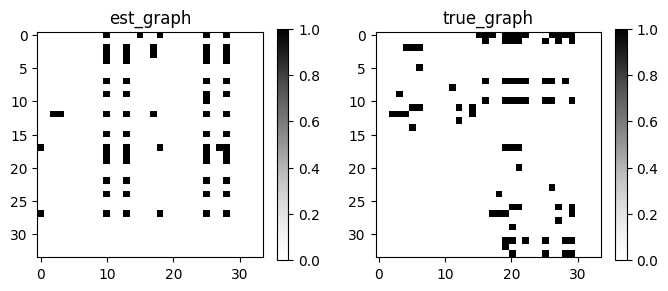

{'fdr': 0.8824, 'tpr': 0.1039, 'fpr': 0.124, 'shd': 122, 'nnz': 68, 'precision': 0.1176, 'recall': 0.1039, 'F1': 0.1103, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [12]:
data = pd.read_csv('data/causalAssembly/station2_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

n = Notears()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

### NOTEARS NON-LINEAR

In [13]:
from castle.algorithms import NotearsNonlinear

#### IID_test data

In [15]:
X, true_dag, _ = load_dataset('IID_Test')
n = NotearsNonlinear()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2024-06-19 12:24:25,768 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-19 12:24:25,830 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2024-06-19 12:24:25,877 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16


KeyboardInterrupt: 

#### station3

##### sample size 500

In [18]:
data = pd.read_csv('data/causalAssembly/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

n = NotearsNonlinear()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

2024-06-19 12:27:36,298 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2024-06-19 12:27:36,301 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=500, d=16, iter_=100, h_=1e-08, rho_=1e+16


KeyboardInterrupt: 

### GAE

In [19]:
from castle.algorithms import GAE

#### IID test data

2024-06-19 12:52:18,003 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-19 12:52:18,004 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-19 12:52:18,007 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-19 12:52:18,017 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 29.175152764308613
2024-06-19 12:52:18,941 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 3.8452682787178256
2024-06-19 12:5

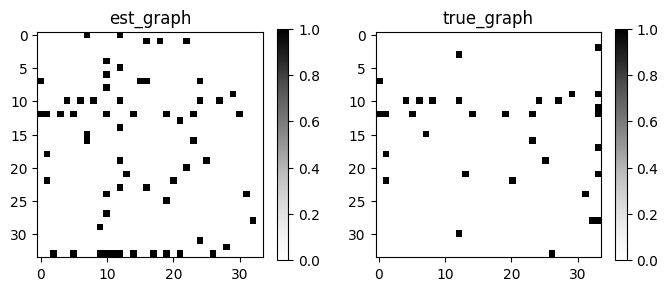

{'fdr': 0.3846, 'tpr': 0.7273, 'fpr': 0.0284, 'shd': 16, 'nnz': 39, 'precision': 0.3871, 'recall': 0.7273, 'F1': 0.5053, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [22]:
dag = DAG.scale_free(n_nodes=34, n_edges=40)
data = IIDSimulation(W=dag, n=1000, method='linear', sem_type='logistic')

model = GAE(epochs=3)
model.learn(data.X)

GraphDAG(model.causal_matrix, data.B)
metrics = MetricsDAG(model.causal_matrix, data.B)
print(metrics.metrics)

#### station 3

In [24]:
data = pd.read_csv('data/causalAssembly/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

n = GAE()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.caus.al_matrix, ground_truth)

2024-06-19 12:55:16,915 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-19 12:55:16,918 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-19 12:55:16,926 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 626358.8149819861


2024-06-19 12:55:17,705 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 610395.3493146903
2024-06-19 12:55:18,466 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 400: 427463.71750273334
2024-06-19 12:55:19,240 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 600: 8219.348102902428
2024-06-19 12:55:20,011 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 800: 1322.4686520675518
2024-06-19 12:55:20,783 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torc

IndexError: index 16 is out of bounds for axis 0 with size 16

## fitted graph

requirements:

3-cell production process

cell_1: 34-40 characteristics (boolean), resembling the vehicle characteristics (originally 670, but correlation analysis limited this to 34-40 relevant ones)

cell_2: 2 characteristics: mean ergonomics and duration. Both are contiunous, but could be binned.
    idea: get continuous data for each and then bin it into 4 bins

cell_3: 1 charactreristic: defect (boolean)

only forward-reaching connections possible from cell i to i+1


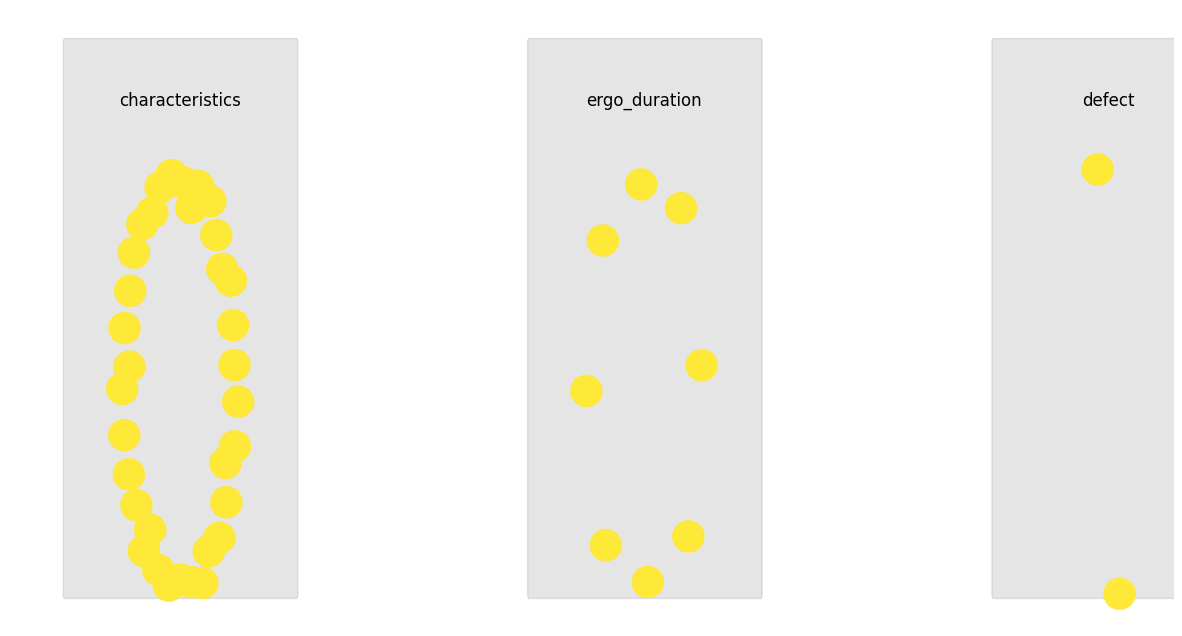

In [6]:
### CREATE GRAPH

custom_line = ProductionLineGraph()

n_characteristics = 34
n_bins_ergo = 4
n_bins_dur = 4

### CELL_1

custom_line.new_cell(name='characteristics')
custom_line.characteristics.add_random_module(n_nodes=n_characteristics, p=0)

### CELL_2

custom_line.new_cell(name='ergo_duration')
# mean ergonomics
custom_line.ergo_duration.add_random_module(n_nodes=n_bins_ergo)
# mean duration
custom_line.ergo_duration.add_random_module(n_nodes=n_bins_dur)

### CELL_3

custom_line.new_cell(name='defect')
custom_line.defect.add_random_module(n_nodes=2)

custom_line.show()
